# Домашнее задание
Когда-нибудь это закончится? Симуляция распространения болезни. Работа с NetworkX.

## Цель:
Перед вами не совсем стандартное домашнее задание, так как в нём практически не будет машинного обучения (если не считать анализа графов), но будет довольно много аналитики, симуляций, визуализаций и очень интересных выводов. Так как не совсем про ML, то и выполнять это задание не обязательно для успешного завершения курса. Но если вам интересно узнать, как можно смоделировать распространение инфекции по международной сети аэропортов, увидеть, как заражение аэропортов-хабов приводит к взрывному росту заболеваний и создать свой локальный Plague Inc., то давайте приступать :)


## Описание/Пошаговая инструкция выполнения домашнего задания:
 - Набор данных представляет собой основные маршруты авиаперелетов в США за один месяц 2008-го года. В качестве модели распространения инфекции предлагается использовать SI (susceptible-infected) модель, в которой каждый аэропорт имеет два возможных состояния - “здоровый” или “зараженный”. Здоровый аэропорт может заразиться с некоторой вероятностью p (infection probability), если к нему прилетает самолет из зараженного города. Инфекция начинает распространение из некоторого стартового аэропорта и заканчивает распространение, когда все перелеты из датасета завершены.
## Часть 1. Пишем симуляцию.
 - Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.
 - В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0).
 
## Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?
 - Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
 - Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.
## Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?
 - Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
 - Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
 - Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
 - Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008

In [1]:
# импорты

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime

import pandas as pd

import json
import requests
import time

import networkx as nx
from networkx.readwrite import json_graph
from networkx.algorithms import community

from collections import Counter

import random
from random import randint

import statistics
from scipy.stats import spearmanr

import tqdm

import folium

In [2]:
np.random.seed(42)

# Дата-фрейм аэропортов

In [3]:
airport_data=pd.read_csv('US_airport_id_info.csv')

In [4]:
airport_data

,id,symbol,airport name,city,latitude,longitude,xcoordviz,ycoordviz
0,0,ABE,Lehigh Valley Intl,Allentown,40.652083,-75.440806,1.926093e+06,337357.529978
1,1,CLE,Cleveland Hopkins Intl,Cleveland,41.411689,-81.849794,1.384469e+06,302554.338074
2,2,CLT,Charlotte Douglas Intl,Charlotte,35.214000,-80.943139,1.590611e+06,-355004.415565
3,3,ORD,Chicago Ohare Intl,Chicago,41.978603,-87.904842,8.790187e+05,289127.727396
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta,33.636719,-84.428067,1.306257e+06,-582505.812325
...,...,...,...,...,...,...,...,...
274,274,RDD,Redding Muni,Redding,40.509000,-122.293389,-1.976890e+06,334403.078441
275,275,SUN,Friedman Mem,Hailey,43.504444,-114.296194,-1.261565e+06,515731.793677
276,276,TWF,Magic Valley Regional Airport,Twin Falls,42.481803,-114.487733,-1.296508e+06,406881.420680
277,277,RHI,Rhinelander Oneida County Airport,Rhinelander,45.631200,-89.467500,7.102613e+05,678171.825235


In [5]:
df_airport_data = airport_data[['id', 'symbol', 'airport name', 'city']].copy()

In [6]:
df_airport_data

,id,symbol,airport name,city
0,0,ABE,Lehigh Valley Intl,Allentown
1,1,CLE,Cleveland Hopkins Intl,Cleveland
2,2,CLT,Charlotte Douglas Intl,Charlotte
3,3,ORD,Chicago Ohare Intl,Chicago
4,4,ATL,Hartsfield Jackson Atlanta Intl,Atlanta
...,...,...,...,...
274,274,RDD,Redding Muni,Redding
275,275,SUN,Friedman Mem,Hailey
276,276,TWF,Magic Valley Regional Airport,Twin Falls
277,277,RHI,Rhinelander Oneida County Airport,Rhinelander


### Отображаю на карте

In [7]:
city = [(38.899513), (-100)]
m = folium.Map(location=city, zoom_start= 4)

In [8]:
for i in tqdm.tqdm(range(airport_data.shape[0])):
    loc = airport_data[['latitude', 'longitude']].loc[i].to_list()
    folium.Circle(radius=10,
                  location=loc,
                  color="green",
                  fill=False).add_to(m)

100%|██████████████████████████████████████████████████████████████████████████████| 279/279 [00:00<00:00, 3429.89it/s]


In [9]:
m.add_child(folium.LatLngPopup())

# Дата-фрейм полетов

In [10]:
flight_data=pd.read_csv('2008.csv')

In [11]:
flight_data.shape

(7009728, 29)

In [12]:
flight_data.shape[0]

7009728

## Для нашей задачи возьму 1/N от flight_data

In [13]:
party = 100
df_flight_data = flight_data.sample(flight_data.shape[0]//party).copy()

In [14]:
df_flight_data.shape

(70097, 29)

## Дата-фрейм полетов. преобразования

In [15]:
df_flight_data.iloc[[0]].T

,1767993
Year,2008
Month,3
DayofMonth,28
DayOfWeek,5
DepTime,920.0
CRSDepTime,925
ArrTime,1159.0
CRSArrTime,1218
UniqueCarrier,CO
FlightNum,1811


Для нашей задачи нам понадобятся только дата и время, аэропорты отправления и назначения, время отправления и прибытия. Итак, нас интересуют следующие столбцы:

- Year
- Month
- DayofMonth
- CRSDepTime - время отправления по расписанию (местное, ччмм, целое число)
- CRSArrTime - запланированное время прибытия (местное, ччмм, целое число)
- Origin - код аэропорта отправления IATA
- Dest - код аэропорта назначения IATA

Поскольку время указано в местном часовом поясе, мы извлечем часовые пояса отсюда и будем использовать их при преобразовании в utc datetime.

Кроме того, мы решили, что DayofMonth — это день вылета рейса, поэтому нам нужно контролировать ночные рейсы.

In [16]:
# спсисок колонок
list_flight_data_columns = ['Year', 'Month', 'DayofMonth', 'CRSDepTime', 'CRSArrTime', 'Origin', 'Dest']

In [17]:
# flight_data_party_5 с нужными колонками
df_flight_data = df_flight_data[list_flight_data_columns].copy()

In [18]:
df_flight_data

,Year,Month,DayofMonth,CRSDepTime,CRSArrTime,Origin,Dest
1767993,2008,3,28,925,1218,CLE,RSW
3073423,2008,6,26,1005,1155,BNA,DEN
922712,2008,2,15,1959,2103,ATL,BQK
1517855,2008,3,10,1010,1326,GRB,ATL
6480817,2008,12,8,1125,1330,BWI,JAX
...,...,...,...,...,...,...,...
3600782,2008,6,17,1240,2115,SEA,JFK
1695213,2008,3,16,1915,2100,DFW,BNA
64596,2008,1,23,1340,1705,AUS,MCO
949595,2008,2,17,1208,1413,BUF,ATL


In [19]:
# какие типы в flight_data?
df_flight_data.dtypes

Year           int64
Month          int64
DayofMonth     int64
CRSDepTime     int64
CRSArrTime     int64
Origin        object
Dest          object
dtype: object

In [20]:
#CRSDepTime, CRSArrTime отделю часы и минуты
df_flight_data['CRSDepTime_h'] = df_flight_data['CRSDepTime'].astype(str).str.slice(stop=-2)
df_flight_data['CRSDepTime_m'] = df_flight_data['CRSDepTime'].astype(str).str.slice(start=-2)

In [21]:
# проверяю, что  время отправления по расписанию (местное, ччмм, целое число) не было в 24-00 с переносом даты +1 день
df_flight_data[df_flight_data['CRSDepTime_h'].str.contains('24')]

,Year,Month,DayofMonth,CRSDepTime,CRSArrTime,Origin,Dest,CRSDepTime_h,CRSDepTime_m


#### время отправления по расписанию (местное, ччмм, целое число) не было в 24-00

In [22]:
# объединение колонок в строку формата YYYY-MM-DD hh:mm
date_str = (df_flight_data['Year'].astype(str) + '-' +
            df_flight_data['Month'].astype(str).str.zfill(2) + '-' +
            df_flight_data['DayofMonth'].astype(str).str.zfill(2) + ' ' +
            df_flight_data['CRSDepTime_h'].astype(str).str.zfill(2) + ':' +
            df_flight_data['CRSDepTime_m'].astype(str).str.zfill(2))

# создание колонки StartTime с помощью метода pd.to_datetime()
df_flight_data['StartTime'] = pd.to_datetime(date_str, format='%Y-%m-%d %H:%M')

In [23]:
#CRSDepTime, CRSArrTime отделю часы и минуты
df_flight_data['CRSArrTime_h'] = df_flight_data['CRSArrTime'].astype(str).str.slice(stop=-2)
df_flight_data['CRSArrTime_m'] = df_flight_data['CRSArrTime'].astype(str).str.slice(start=-2)

In [24]:
# проверяю, что  запланированное время прибытия (местное, ччмм, целое число) не было в 24-00 с переносом даты +1 день
df_flight_data[df_flight_data['CRSArrTime_h'].str.contains('24')]

,Year,Month,DayofMonth,CRSDepTime,CRSArrTime,Origin,Dest,CRSDepTime_h,CRSDepTime_m,StartTime,CRSArrTime_h,CRSArrTime_m
1033568,2008,2,10,500,2400,GFK,MSP,5,00,2008-02-10 05:00:00,24,00
458395,2008,1,1,620,2400,CID,DTW,6,20,2008-01-01 06:20:00,24,00
3459158,2008,6,15,1320,2400,FWA,DTW,13,20,2008-06-15 13:20:00,24,00
1652504,2008,3,12,705,2400,GSP,MEM,7,05,2008-03-12 07:05:00,24,00
1646156,2008,3,29,805,2400,HLN,MSP,8,05,2008-03-29 08:05:00,24,00
2245437,2008,4,3,2102,2400,DTW,GSP,21,02,2008-04-03 21:02:00,24,00


### запланированное время прибытия (местное, ччмм, целое число) было в 24-00 -> с переносом в другой день -> применю трюк и заменю 24 час на 23, а минуты на 59, т.е. время прилета будет 23:59 этого же дня

In [25]:
df_flight_data.loc[df_flight_data['CRSArrTime_h'].str.contains('24'), 'CRSArrTime_h'] = '23'
df_flight_data.loc[df_flight_data['CRSArrTime_h'].str.contains('24'), 'CRSArrTime_m'] = '59'

In [26]:
df_flight_data[df_flight_data['CRSArrTime_h'].str.contains('24')]

,Year,Month,DayofMonth,CRSDepTime,CRSArrTime,Origin,Dest,CRSDepTime_h,CRSDepTime_m,StartTime,CRSArrTime_h,CRSArrTime_m


### запланированное время прибытия (местное, ччмм, целое число) не было в 24-00

In [27]:
# объединение колонок в строку формата YYYY-MM-DD hh:mm
date_str = (df_flight_data['Year'].astype(str) + '-' +
            df_flight_data['Month'].astype(str).str.zfill(2) + '-' +
            df_flight_data['DayofMonth'].astype(str).str.zfill(2) + ' ' +
            df_flight_data['CRSArrTime_h'].astype(str).str.zfill(2) + ':' +
            df_flight_data['CRSArrTime_m'].astype(str).str.zfill(2))

# создание колонки StartTime с помощью метода pd.to_datetime()
df_flight_data['EndTime'] = pd.to_datetime(date_str, format='%Y-%m-%d %H:%M')

## Сортируем перелеты по времени вылета

In [28]:
df_flight_data = df_flight_data.sort_values(by='StartTime').copy()

In [29]:
df_flight_data = df_flight_data[['Origin', 'Dest', 'StartTime', 'EndTime']].copy()

In [30]:
df_flight_data

,Origin,Dest,StartTime,EndTime
568130,LAX,IAH,2008-01-01 01:35:00,2008-01-01 06:34:00
354314,DAY,ATL,2008-01-01 05:55:00,2008-01-01 07:30:00
472920,ELM,DTW,2008-01-01 06:00:00,2008-01-01 07:30:00
229641,LAX,DEN,2008-01-01 06:00:00,2008-01-01 09:22:00
487580,ELP,DFW,2008-01-01 06:00:00,2008-01-01 08:35:00
...,...,...,...,...
6809298,ATL,MCO,2008-12-31 22:05:00,2008-12-31 23:31:00
6729192,CLT,IAH,2008-12-31 22:10:00,2008-12-31 23:53:00
6757912,HNL,LAX,2008-12-31 23:20:00,2008-12-31 06:40:00
6862447,HNL,LAX,2008-12-31 23:20:00,2008-12-31 06:50:00


### соединю df_flight_data и df_airport_data

In [31]:
df_flight_data = pd.merge(df_flight_data, df_airport_data[['symbol', 'city', 'id']], how = 'left', left_on = 'Origin', right_on = 'symbol')
df_flight_data.drop(columns = 'symbol', inplace = True)
df_flight_data.rename(columns = {'city':'city_origin'}, inplace = True)

In [32]:
df_flight_data = pd.merge(df_flight_data, df_airport_data[['symbol', 'city']], how = 'left', left_on = 'Dest', right_on = 'symbol')
df_flight_data.drop(columns = 'symbol', inplace = True)
df_flight_data.rename(columns = {'city':'city_dest'}, inplace = True)

In [33]:
df_flight_data.head(3)

,Origin,Dest,StartTime,EndTime,city_origin,id,city_dest
0,LAX,IAH,2008-01-01 01:35:00,2008-01-01 06:34:00,Los Angeles,16.0,Houston
1,DAY,ATL,2008-01-01 05:55:00,2008-01-01 07:30:00,Dayton,91.0,Atlanta
2,ELM,DTW,2008-01-01 06:00:00,2008-01-01 07:30:00,Elmira,237.0,Detroit


In [34]:
#удалю пустые: id == nan. прсмотр
df_flight_data.loc[df_flight_data['id'].isna()]

,Origin,Dest,StartTime,EndTime,city_origin,id,city_dest
708,HHH,ATL,2008-01-04 12:25:00,2008-01-04 13:59:00,NaN,NaN,Atlanta
720,SPS,DFW,2008-01-04 13:43:00,2008-01-04 14:35:00,NaN,NaN,Dallas-fort Worth
3552,SPS,DFW,2008-01-18 18:07:00,2008-01-18 19:00:00,NaN,NaN,Dallas-fort Worth
4838,SPS,DFW,2008-01-25 15:38:00,2008-01-25 16:30:00,NaN,NaN,Dallas-fort Worth
5516,PMD,SFO,2008-01-29 06:00:00,2008-01-29 07:17:00,NaN,NaN,San Francisco
...,...,...,...,...,...,...,...
55089,PMD,SFO,2008-10-07 10:35:00,2008-10-07 12:07:00,NaN,NaN,San Francisco
56440,HHH,ATL,2008-10-14 17:05:00,2008-10-14 18:32:00,NaN,NaN,Atlanta
59459,HHH,ATL,2008-10-31 17:05:00,2008-10-31 18:32:00,NaN,NaN,Atlanta
60025,PMD,SFO,2008-11-04 06:00:00,2008-11-04 07:37:00,NaN,NaN,San Francisco


In [35]:
#удалю пустые: id == nan. удаление
df_flight_data.loc[df_flight_data['id'].isna()].index
df_flight_data = df_flight_data.drop(index = df_flight_data.loc[df_flight_data['id'].isna()].index)

In [36]:
#df_flight_data['id'] в int
df_flight_data['id'] = df_flight_data['id'].astype(int)

In [37]:
df_flight_data

,Origin,Dest,StartTime,EndTime,city_origin,id,city_dest
0,LAX,IAH,2008-01-01 01:35:00,2008-01-01 06:34:00,Los Angeles,16,Houston
1,DAY,ATL,2008-01-01 05:55:00,2008-01-01 07:30:00,Dayton,91,Atlanta
2,ELM,DTW,2008-01-01 06:00:00,2008-01-01 07:30:00,Elmira,237,Detroit
3,LAX,DEN,2008-01-01 06:00:00,2008-01-01 09:22:00,Los Angeles,16,Denver
4,ELP,DFW,2008-01-01 06:00:00,2008-01-01 08:35:00,El Paso,13,Dallas-fort Worth
...,...,...,...,...,...,...,...
70092,ATL,MCO,2008-12-31 22:05:00,2008-12-31 23:31:00,Atlanta,4,Orlando
70093,CLT,IAH,2008-12-31 22:10:00,2008-12-31 23:53:00,Charlotte,2,Houston
70094,HNL,LAX,2008-12-31 23:20:00,2008-12-31 06:40:00,Hickam Afb,55,Los Angeles
70095,HNL,LAX,2008-12-31 23:20:00,2008-12-31 06:50:00,Hickam Afb,55,Los Angeles


In [38]:
df_flight_data['count'] = df_flight_data.groupby('Origin')[['id']].count().shape[0]

In [39]:
df_flight_data

,Origin,Dest,StartTime,EndTime,city_origin,id,city_dest,count
0,LAX,IAH,2008-01-01 01:35:00,2008-01-01 06:34:00,Los Angeles,16,Houston,278
1,DAY,ATL,2008-01-01 05:55:00,2008-01-01 07:30:00,Dayton,91,Atlanta,278
2,ELM,DTW,2008-01-01 06:00:00,2008-01-01 07:30:00,Elmira,237,Detroit,278
3,LAX,DEN,2008-01-01 06:00:00,2008-01-01 09:22:00,Los Angeles,16,Denver,278
4,ELP,DFW,2008-01-01 06:00:00,2008-01-01 08:35:00,El Paso,13,Dallas-fort Worth,278
...,...,...,...,...,...,...,...,...
70092,ATL,MCO,2008-12-31 22:05:00,2008-12-31 23:31:00,Atlanta,4,Orlando,278
70093,CLT,IAH,2008-12-31 22:10:00,2008-12-31 23:53:00,Charlotte,2,Houston,278
70094,HNL,LAX,2008-12-31 23:20:00,2008-12-31 06:40:00,Hickam Afb,55,Los Angeles,278
70095,HNL,LAX,2008-12-31 23:20:00,2008-12-31 06:50:00,Hickam Afb,55,Los Angeles,278


## получил дата-фрейм: 
- "Origin, "Dest" - аэропорты
- "StartTime", "EndTime" - время вылета, прилета
- "id"	"airport name"	"city" - информация о городе, аэропорте
- "count" количество аэропортов

## Часть 1. Пишем симуляцию.
 - Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.
 - В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0).

In [40]:
# Функция
def simulate_infection(df=df_flight_data, start_node=0, p=1):
    data = df
    infected_airports = {0: data.loc[data['id'] == 0, 'Origin'].min()}
    infected_city = {0: data.loc[data['id'] == 0, 'city_origin'].min()}
    infected_time = {0: data.loc[data['id'] == 0, 'StartTime'].min()}
    for row in data.itertuples():
        if row.Origin in infected_airports.values():  # if the origin airport is infected
            if random.random() < p:  # check if infection spreads to destination airport
                infected_city[row.Index+1] = row.city_dest
                infected_airports[row.Index+1] = row.Dest
                infected_time[row.Index+1] = row.EndTime
    df_temp = pd.DataFrame(data= [infected_time.values(), infected_city.values(), infected_airports.values()]).T.rename(columns = {0: 'time', 1: 'city', 2: 'airport'})
    df_temp_gr = df_temp.groupby('airport')[['time']].min().reset_index()
    time_city_dict = dict(zip(df_temp_gr['time'], df_temp_gr['airport']))
    df_temp = df_temp.groupby(['city', 'airport'])[['time']].min().reset_index().set_index('time')
    return time_city_dict, df_temp

### Функция тест

In [41]:
time_city_dict, df_temp = simulate_infection(start_node=0, p=0.1)

In [42]:
time_city_dict

{Timestamp('2008-01-10 06:40:00'): 'ABE',
 Timestamp('2008-01-29 20:30:00'): 'ABI',
 Timestamp('2008-02-15 20:05:00'): 'ABQ',
 Timestamp('2008-08-25 15:04:00'): 'ACK',
 Timestamp('2008-09-24 14:08:00'): 'ACT',
 Timestamp('2008-02-13 08:39:00'): 'ACV',
 Timestamp('2008-02-19 20:37:00'): 'AEX',
 Timestamp('2008-04-30 14:16:00'): 'AGS',
 Timestamp('2008-01-19 13:30:00'): 'ALB',
 Timestamp('2008-02-06 10:35:00'): 'AMA',
 Timestamp('2008-01-28 14:45:00'): 'ANC',
 Timestamp('2008-02-05 21:39:00'): 'ASE',
 Timestamp('2008-01-10 09:05:00'): 'ATL',
 Timestamp('2008-03-06 17:41:00'): 'ATW',
 Timestamp('2008-01-18 22:51:00'): 'AUS',
 Timestamp('2008-01-23 22:58:00'): 'AVL',
 Timestamp('2008-10-04 22:55:00'): 'AVP',
 Timestamp('2008-03-10 15:00:00'): 'AZO',
 Timestamp('2008-01-10 23:58:00'): 'BDL',
 Timestamp('2008-08-16 13:26:00'): 'BET',
 Timestamp('2008-05-24 09:08:00'): 'BFL',
 Timestamp('2008-07-21 15:40:00'): 'BGR',
 Timestamp('2008-02-16 15:53:00'): 'BHM',
 Timestamp('2008-05-27 22:37:00'):

In [43]:
#таблица
df_temp

,city,airport
time,,
2008-02-19 11:45:00,AKRON,CAK
2008-01-29 20:30:00,Abilene,ABI
2008-01-19 13:30:00,Albany,ALB
2008-02-15 20:05:00,Albuquerque,ABQ
2008-02-19 20:37:00,Alexandria,AEX
...,...,...
2008-01-15 21:50:00,White Plains,HPN
2008-01-28 20:38:00,Wichita,ICT
2008-08-23 21:52:00,Wilmington,ILM


In [44]:
df_count = pd.DataFrame(data=time_city_dict.values(), index=time_city_dict.keys(), columns = ['Origin']).resample('12H').count()

<Axes: >

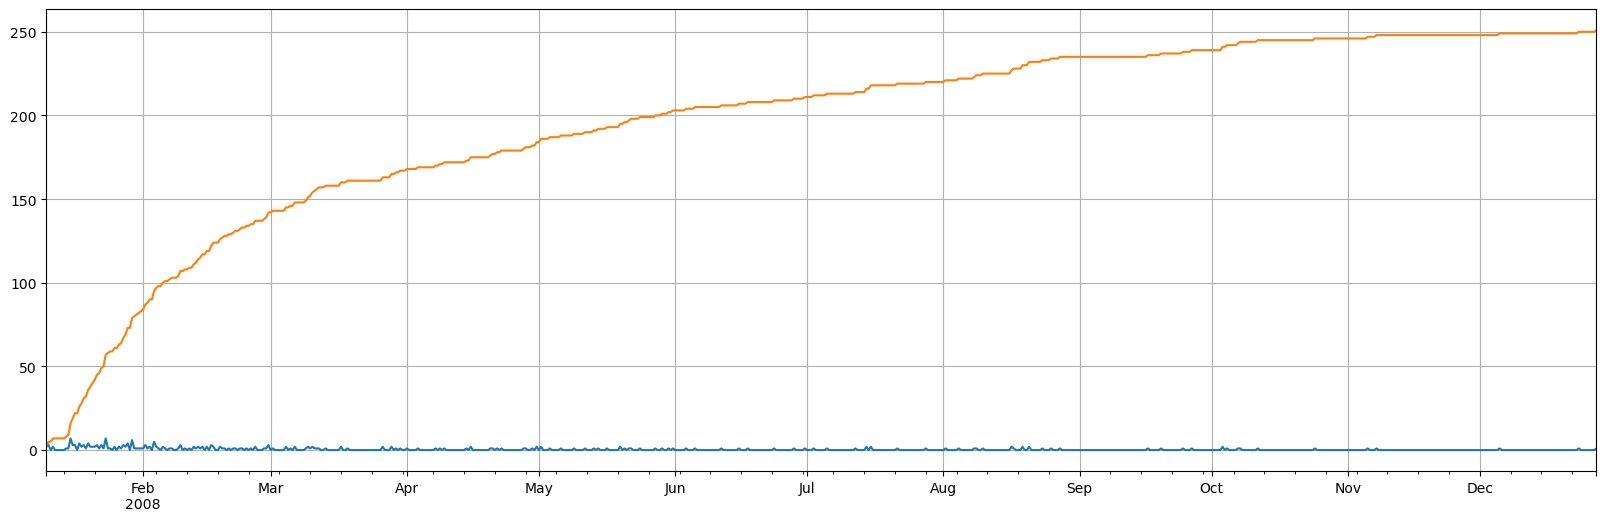

In [45]:
df_count['Origin'].plot(figsize = (20,6), grid=True)
df_count['Origin'].cumsum().plot(figsize = (20,6), grid=True)

## Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?
 - Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
 - Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

In [46]:
prob=[0.01, 0.05, 0.1, 0.5, 1.]
n_simulatiion = 10
results_airport = []
results_city = []
for p in tqdm.tqdm(prob):
    df_list_airport = []
    df_list_city = []
    for _ in tqdm.tqdm(range(n_simulatiion)):
        df_temp = simulate_infection(p=p)[1]
        
        df_temp_airport = df_temp['airport']
        df_temp_airport = df_temp_airport.resample('12H').count()
        df_list_airport.append(df_temp_airport)
        
        df_temp_city = df_temp['city']
        df_temp_city = df_temp_city.resample('12H').count()
        df_list_city.append(df_temp_city)
        
    results_airport.append(df_list_airport)
    results_city.append(df_list_city)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.26s/it]


In [47]:
print(f'проведено {n_simulatiion}, просмотрено {len(results_airport)} зарозностей: {prob}')

проведено 10, просмотрено 5 зарозностей: [0.01, 0.05, 0.1, 0.5, 1.0]


In [48]:
len(df_flight_data['Origin'].unique())

278

In [49]:
df_results_airport_prec = pd.DataFrame()
for i, el in enumerate(prob):
    df_results_airport_prec[el] = pd.DataFrame(results_airport[i]).T.fillna(0).mean(axis=1).cumsum()/len(df_flight_data['Origin'].unique())*100

In [50]:
#Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, 
#был заражен к этому моменту времени. 
df_results_airport_prec.fillna(100, inplace=True)
df_results_airport_prec = df_results_airport_prec.round(2)
df_results_airport_prec

,0.01,0.05,0.10,0.50,1.00
time,,,,,
2008-01-10 00:00:00,0.36,0.43,0.36,0.90,2.88
2008-01-10 12:00:00,0.36,0.43,0.36,1.91,10.79
2008-01-11 00:00:00,0.36,0.43,0.36,3.24,18.35
2008-01-11 12:00:00,0.36,0.47,0.36,6.62,29.50
2008-01-12 00:00:00,0.36,0.47,0.36,8.17,32.37
...,...,...,...,...,...
2008-12-29 12:00:00,14.28,64.14,83.71,98.78,100.00
2008-12-30 00:00:00,14.28,64.14,83.71,98.78,100.00
2008-12-30 12:00:00,14.32,64.24,83.78,98.78,100.00


<Axes: xlabel='time'>

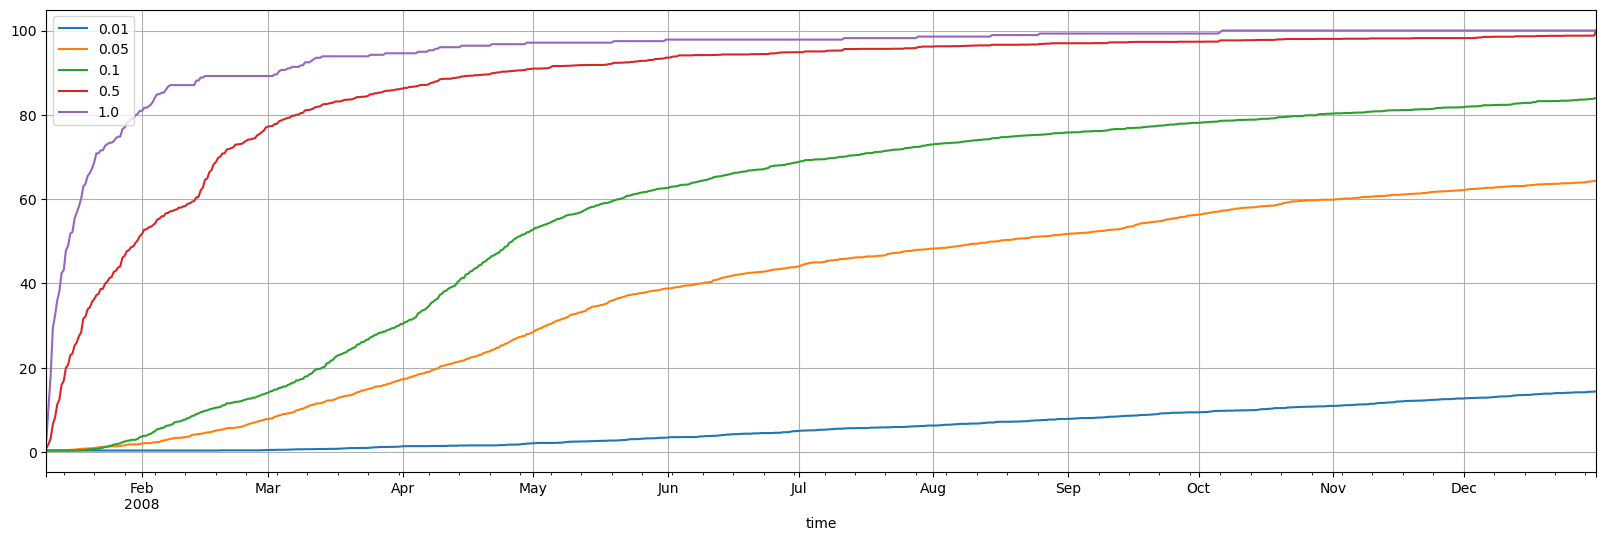

In [51]:
#график какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени.
df_results_airport_prec.plot(figsize = (20,6), grid = True)

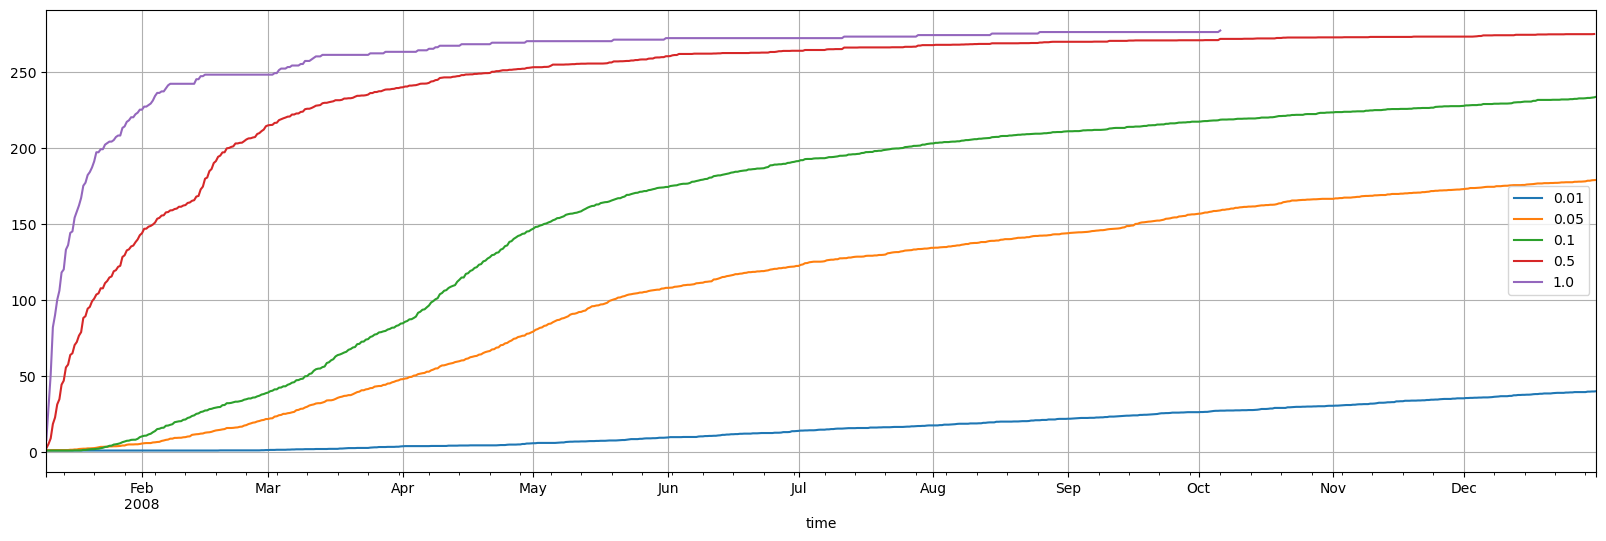

In [52]:
#Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей
for el in results_city:
    pd.DataFrame(el).T.fillna(0).mean(axis=1).cumsum().plot(figsize = (20,6))
    plt.grid()
    plt.legend(prob)

## Вывод: проведена симуляция распостранения инфекции заразность влиияет на скорость распостранения инфекции, чем выше зарозность тем выше скорость распостранения инфекции

## Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?
 - Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
 - Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
 - Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
 - Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?

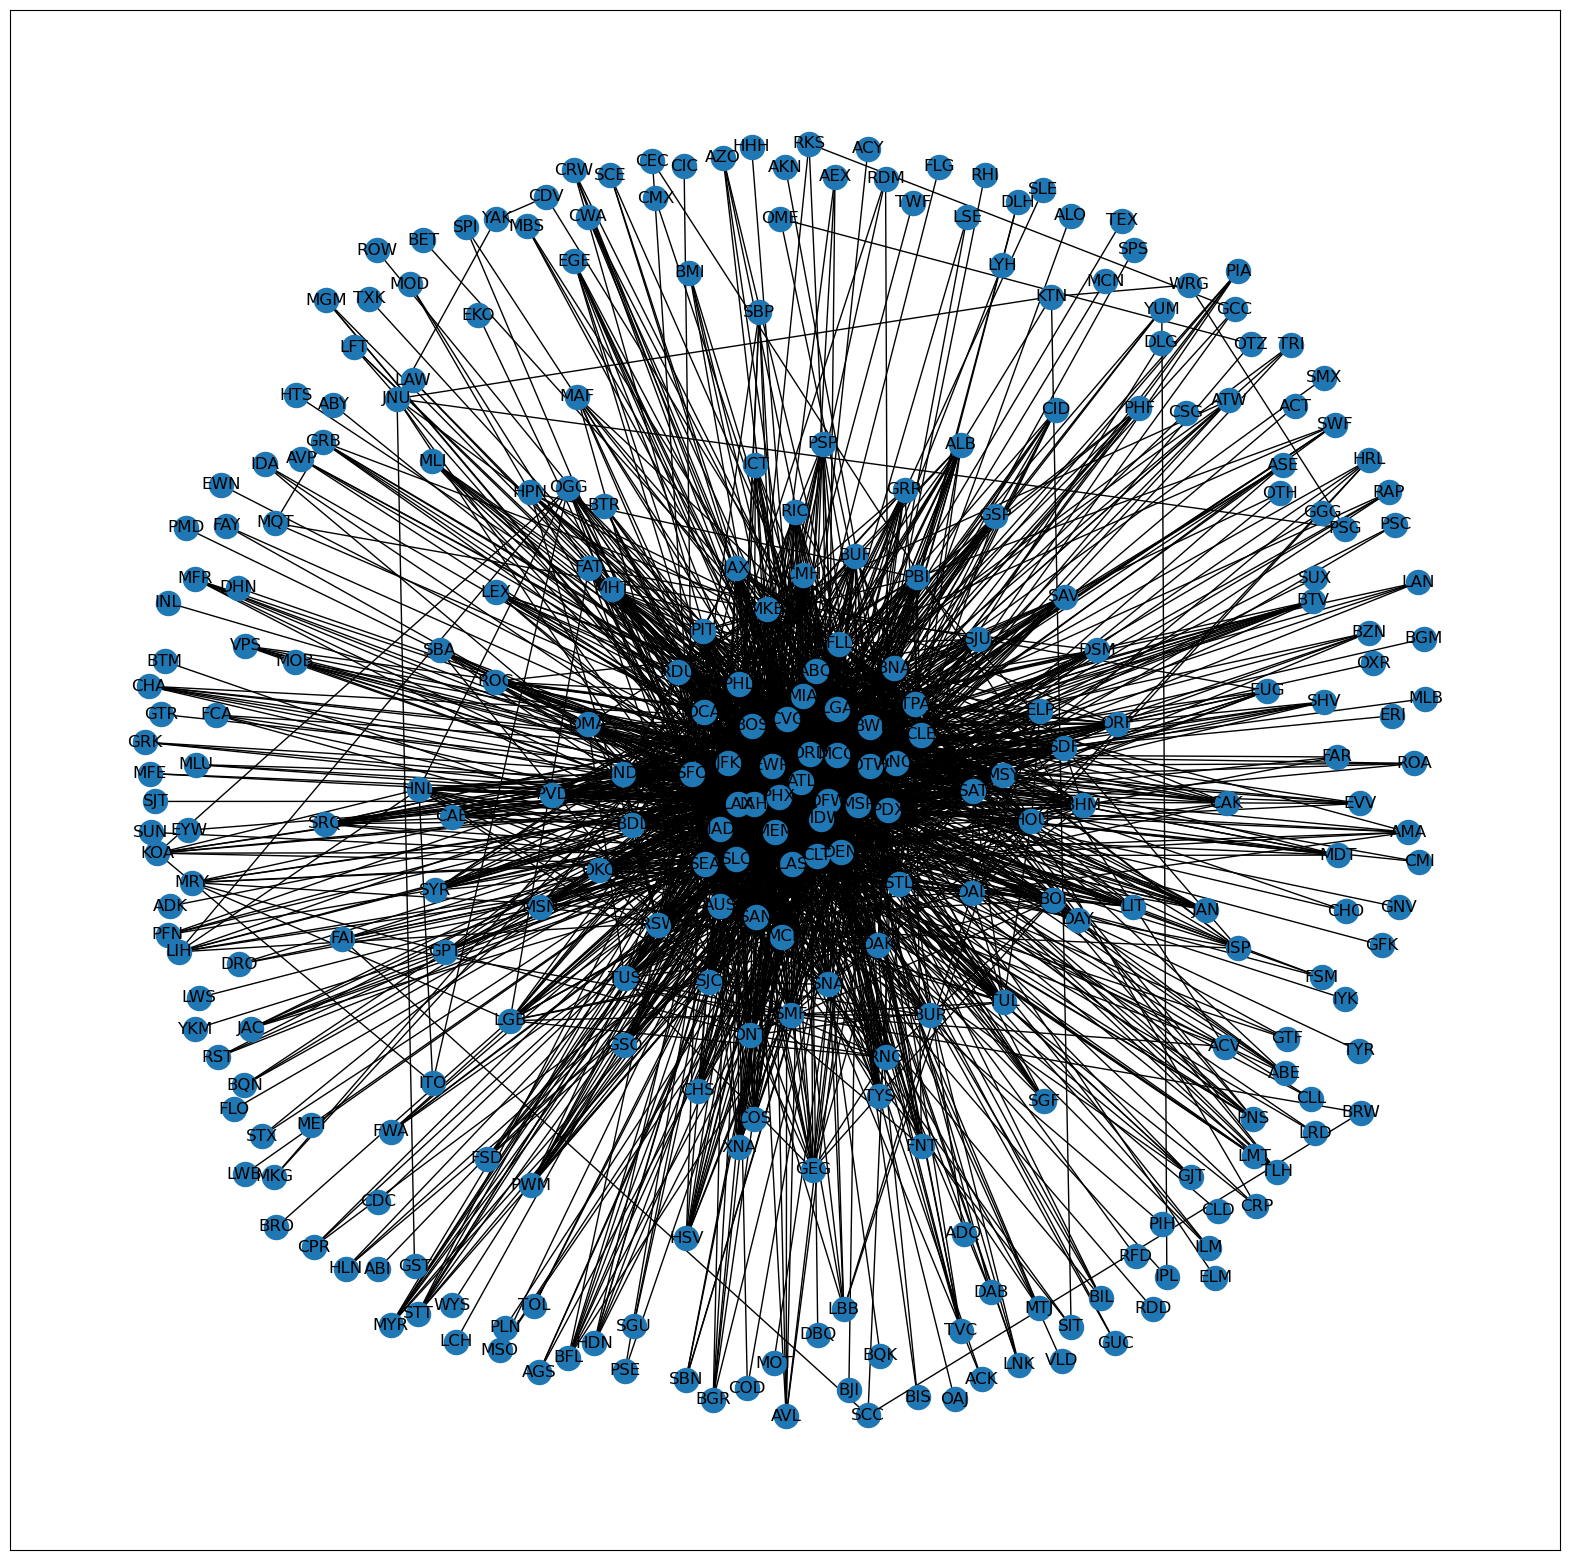

In [53]:
# Создаем граф
G = nx.Graph()

# Загружаем данные из дата-фрейма
#df_flight_data = pd.read_csv('flight_data.csv')

# Добавляем ребра и их веса в граф
for index, row in df_flight_data.iterrows():
    origin = row['Origin']
    dest = row['Dest']
    count = row['count']
    if G.has_edge(origin, dest):
        G[origin][dest]['weight'] += count
    else:
        G.add_edge(origin, dest, weight=count)

# Нормализуем веса ребер
total_flights = sum([d['weight'] for (u, v, d) in G.edges(data=True)])
for (u, v, d) in G.edges(data=True):
    d['weight'] /= total_flights

# Визуализируем граф
fig = plt.figure(1, figsize=(20, 20))
nx.draw_networkx(G, with_labels=True)
plt.show()

##### Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.

In [54]:
dict_temp, df_temp = simulate_infection(p=0.5)

In [55]:
df_simulated_infec = pd.DataFrame()
for i in range(50):
    df_res = pd.DataFrame(dict_temp.values(), index = dict_temp.keys())
    df_simulated_infec = pd.concat([df_simulated_infec, df_res])

In [56]:
df_simulated_infec.columns = ['symbol']

In [57]:
df_simulated_infec = df_simulated_infec.reset_index().merge(airport_data[['symbol', 'city']], on = 'symbol', how = 'left')

In [58]:
df_simulated_infec['start_time'] = df_simulated_infec['index'].min()

In [59]:
df_simulated_infec['timedelta'] = df_simulated_infec['index'] - df_simulated_infec['start_time']

In [60]:
df_simulated_infec = df_simulated_infec.groupby(['symbol', 'city'])[['timedelta']].median().reset_index()

In [61]:
df_simulated_infec = df_simulated_infec.set_index('symbol')

##### Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).

Функция `nx.clustering(G, weight='weight')` возвращает матрицу кластеризации графа `G`, где каждый элемент матрицы представляет собой кластер, состоящий из узлов, связанных ребрами с одинаковым весом. В данном случае, вес ребра определяется как сумма весов ребер, соединяющих два узла.

Функция `nx.degree(G, weight='weight')` возвращает словарь, где ключами являются узлы графа, а значениями - количество ребер, соединяющих этот узел.

Функция `nx.betweenness_centrality(G, weight='weight')` возвращает функцию центральности, которая оценивает важность каждого узла в графе. Чем выше значение функции, тем более центральным является узел.

In [62]:
clustering = nx.clustering(G, weight='weight')
degree = dict(G.degree(weight='weight'))
centrality = nx.betweenness_centrality(G, weight='weight')

In [63]:
clustering

{'LAX': 0.05485433598336378,
 'IAH': 0.03246954136462068,
 'DAY': 0.10397097855871174,
 'ATL': 0.02445227752968394,
 'ELM': 0,
 'DTW': 0.027216201054737547,
 'DEN': 0.033354504118815936,
 'ELP': 0.08373523926775696,
 'DFW': 0.028912299759349832,
 'MEM': 0.032735246606216004,
 'MSP': 0.023656986171497123,
 'RDU': 0.08142266418491036,
 'SRQ': 0.03709195274192982,
 'ORD': 0.03037092549503473,
 'CLT': 0.05411988509779815,
 'CID': 0.12451425752643537,
 'LGA': 0.06516570448016028,
 'PIT': 0.09328091989353632,
 'IAD': 0.04018941504879509,
 'CLE': 0.04087611027027963,
 'OKC': 0.06892873001499873,
 'GRR': 0.09214889570172412,
 'CVG': 0.02259635812392811,
 'ONT': 0.05739240535419577,
 'PHX': 0.05277490969139364,
 'RSW': 0.06091053676582699,
 'ANC': 0.02053550707331533,
 'ADQ': 0,
 'BTR': 0.15799779690295718,
 'TLH': 0.06209506249821065,
 'MCO': 0.04733181607222506,
 'IND': 0.07883606359532742,
 'DCA': 0.0725897932124966,
 'SJU': 0.08699869420905118,
 'MIA': 0.06683827526873104,
 'LAS': 0.0520480

In [64]:
node_metrics = pd.DataFrame.from_dict(clustering ,orient="index", columns=["Clustering"]).join([
    pd.DataFrame.from_dict(degree ,orient="index", columns=["Degree"]),
    pd.DataFrame.from_dict(centrality ,orient="index", columns=["Centrality"])])

In [65]:
node_metrics

,Clustering,Degree,Centrality
LAX,0.054854,0.061987,0.101406
IAH,0.032470,0.052846,0.100260
DAY,0.103971,0.005013,0.000000
ATL,0.024452,0.115261,0.183181
ELM,0.000000,0.000400,0.000000
...,...,...,...
LMT,0.045623,0.000186,0.000000
GST,0.000000,0.000014,0.000000
LWB,0.000000,0.000014,0.000000
HTS,0.000000,0.000057,0.000000


In [66]:
node_metrics.sort_values("Centrality", ascending=False).head()

,Clustering,Degree,Centrality
ATL,0.024452,0.115261,0.183181
CVG,0.022596,0.025852,0.172424
MSP,0.023657,0.036664,0.171280
SLC,0.023721,0.038320,0.131403
FLL,0.052556,0.019024,0.108937


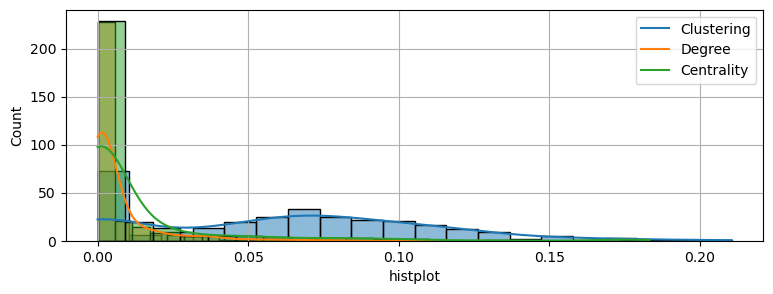

In [67]:
fig = plt.figure(1, figsize=(9, 3))

sns.histplot(node_metrics['Clustering'], bins = 20, kde = True)
sns.histplot(node_metrics['Degree'], bins = 20, kde = True)
sns.histplot(node_metrics['Centrality'], bins = 20, kde = True)

plt.legend(['Clustering', 'Degree', 'Centrality'])
plt.grid()
plt.xlabel('histplot')
plt.show()

###### Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты.

In [68]:
df_simulated_infec = df_simulated_infec.join(node_metrics)

In [69]:
def convert_to_seconds(timedelta_value):
    return timedelta_value.total_seconds()  *  3600

# применяем функцию к каждой строке DataFrame
df_simulated_infec['seconds'] = df_simulated_infec['timedelta'].apply(convert_to_seconds) #время заражения

In [70]:
df_simulated_infec.columns

Index(['city', 'timedelta', 'Clustering', 'Degree', 'Centrality', 'seconds'], dtype='object')

<Axes: xlabel='seconds', ylabel='Centrality'>

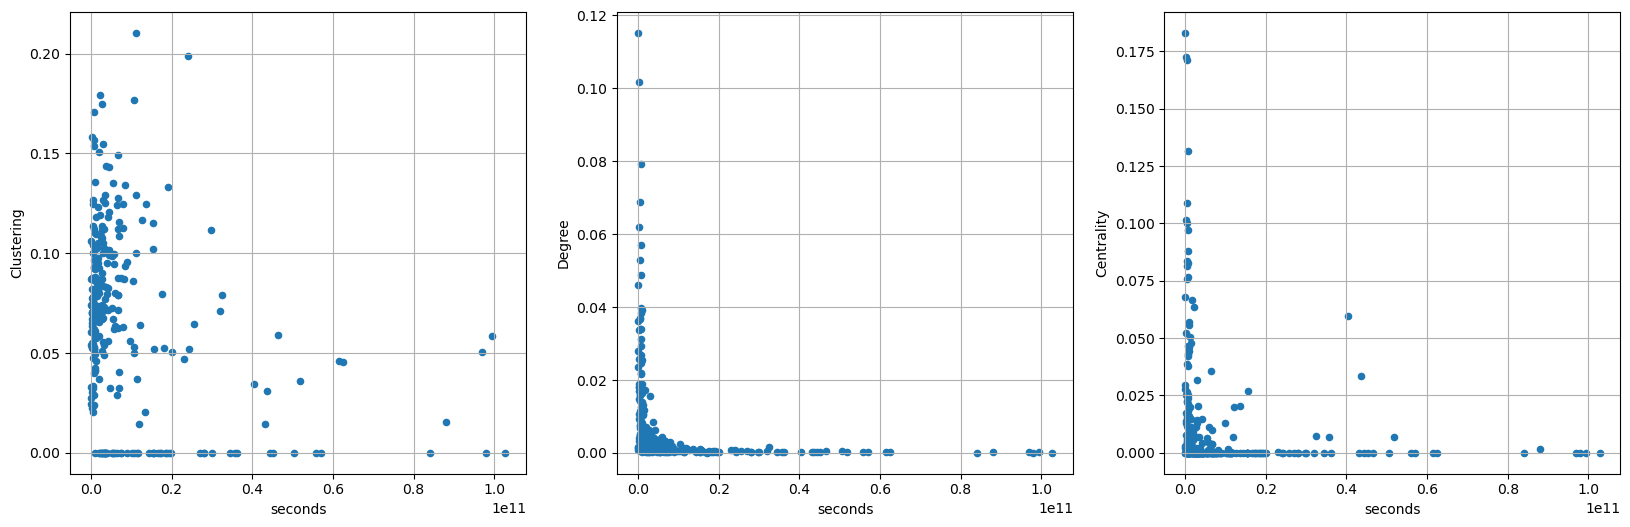

In [71]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

df_simulated_infec.plot(x='seconds', y='Clustering', kind='scatter', grid=True, figsize = (20,6), ax=axes[0])
df_simulated_infec.plot(x='seconds', y='Degree', kind='scatter', grid=True, figsize = (20,6), ax=axes[1])
df_simulated_infec.plot(x='seconds', y='Centrality', kind='scatter', grid=True, figsize = (20,6), ax=axes[2])

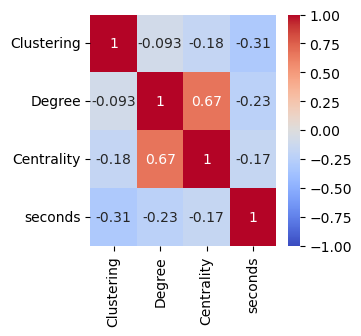

In [72]:
df = df_simulated_infec[['Clustering', 'Degree', 'Centrality', 'seconds']] # - матрица корреляций [прямолинейная связь, y = kx +b]
df.corr()
plt.subplots(figsize=(3,3))
sns.heatmap(df.corr(), cmap=sns.color_palette("coolwarm", 10000), vmin=-1, center=0, annot = True)

plt.show()

interval columns not set, guessing: ['Clustering', 'Degree', 'Centrality', 'seconds']
interval columns not set, guessing: ['Clustering', 'Degree', 'Centrality', 'seconds']


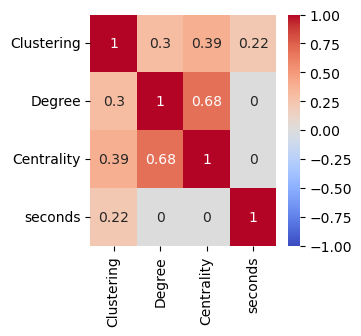

In [73]:
import phik

df = df_simulated_infec[['Clustering', 'Degree', 'Centrality', 'seconds']] # - матрица корреляций [прямолинейная связь, y = kx +b]
df.phik_matrix() # - матрица phik корреляций [линейная связь, y = kx +b, x^2, ln(x) и т.п.]
plt.subplots(figsize=(3,3))
sns.heatmap(df.phik_matrix(), cmap=sns.color_palette("coolwarm", 10000), vmin=-1, center=0, annot = True)
plt.show()

# Вывод: 
- Медианное время заражения ('seconds') имеет корреляцию с 'Clustering'. Аэропорты с более высоким коэффициентом кластеризации заражаются позже, чем с более низким. Между аэропортами внутри кластера выполняется много рейсов, и меньше рейсов в аэропорты за пределами кластера, что затрудняет распространение инфекции по территории кластера и ее попадание в рассматриваемый аэропорт. 